In [16]:
import sqlite3
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
# Step 1: Connect to the SQLite database
db_path = './small_data.db'
conn = sqlite3.connect(db_path)

In [18]:
# Step 2: Fetch distinct normalized names from the database
fetch_names_query = "SELECT normalized_name FROM sample_data WHERE normalized_name IS NOT NULL;"
names = pd.read_sql_query(fetch_names_query, conn)['normalized_name'].tolist()

In [19]:
for i in range(5):
    print(names[i])

1 l sek sut
1 l sek sut
1 l sek sut
1 l sek sut
1 l sek sut


In [20]:
# Step 3: Convert product names into TF-IDF vectors
vectorizer = TfidfVectorizer()
name_vectors = vectorizer.fit_transform(names)

In [21]:
# Step 4: Calculate cosine similarity and apply DBSCAN clustering
distance_matrix = 1 - cosine_similarity(name_vectors)

# Ensure non-negative distances
distance_matrix[distance_matrix < 0] = 0

# Apply DBSCAN clustering
clustering_model = DBSCAN(eps=0.6, min_samples=4, metric='precomputed')
clusters = clustering_model.fit_predict(distance_matrix)

In [22]:
# Step 5: Map clusters to canonical names
name_clusters = pd.DataFrame({'name': names, 'cluster': clusters})

# Assign canonical names (e.g., the shortest name in each cluster)
canonical_names = (
    name_clusters.groupby('cluster')['name']
    .apply(lambda x: min(x, key=len) if x.name != -1 else None)  # Shortest name for each cluster
    .to_dict()
)

# Map names to their canonical form
name_clusters['canonical_name'] = name_clusters['cluster'].map(canonical_names)

In [23]:
# Step 6: Update the database with canonical names
update_query = "UPDATE sample_data SET normalized_name = ? WHERE normalized_name = ?;"
for _, row in name_clusters.iterrows():
    if row['canonical_name']:
        conn.execute(update_query, (row['canonical_name'], row['name']))

# Commit the updates
conn.commit()

In [24]:
# Step 7: Verify the updates by fetching a sample of rows
verify_query = "SELECT normalized_name FROM sample_data LIMIT 10;"
updated_rows = pd.read_sql_query(verify_query, conn)

# Display the updated rows
print(updated_rows)

  normalized_name
0     1 l sek sut
1     1 l sek sut
2     1 l sek sut
3     1 l sek sut
4     1 l sek sut
5     1 l sek sut
6     1 l sek sut
7     1 l sek sut
8     1 l sek sut
9     1 l sek sut


In [25]:
# Close the connection
conn.close()

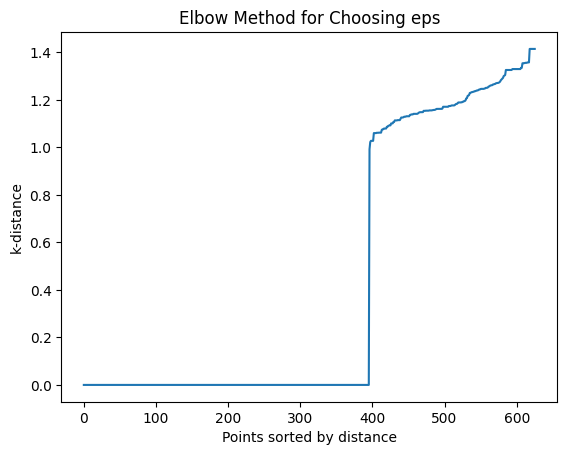

In [26]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Calculate the k-distance graph
k = 4  # Typically, use min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(name_vectors)
distances, _ = neighbors_fit.kneighbors(name_vectors)

# Sort distances for k-th nearest neighbor
distances = np.sort(distances[:, k-1], axis=0)

# Plot the distances to find the elbow
plt.plot(distances)
plt.ylabel('k-distance')
plt.xlabel('Points sorted by distance')
plt.title('Elbow Method for Choosing eps')
plt.show()